# TeleQnA Preprocessing

In [1]:
import json
import pandas as pd
import re

# Step 1: Load TeleQnA.json
with open("TeleQnA.json", "r", encoding="utf-8") as f:
    teleqna_data = json.load(f)

In [2]:
# Step 2: Convert to Structured DataFrame
processed_data = []
for _, entry in teleqna_data.items():
    options = [entry.get(f"option {i}", "").strip() for i in range(1, 6) if f"option {i}" in entry]
    
    processed_data.append({
        "question": entry.get("question", "").strip(),
        "option_a": entry.get("option 1", "").strip(),
        "option_b": entry.get("option 2", "").strip(),
        "option_c": entry.get("option 3", "").strip(),
        "option_d": entry.get("option 4", "").strip(),
        "option_e": entry.get("option 5", "").strip() if "option 5" in entry else "",
        "options": options,
        "answer": entry.get("answer", "").strip(),
        "explanation": entry.get("explanation", "").strip(),
        "category": entry.get("category", "").strip()
    })

df = pd.DataFrame(processed_data)

In [3]:
df

,question,option_a,option_b,option_c,option_d,option_e,options,answer,explanation,category
0,What is the purpose of the Nmfaf_3daDataManage...,To configure the MFAF to map data or analytics...,To configure the MFAF to stop mapping data or ...,To supply data or analytics from the MFAF to n...,To fetch data or analytics from the MFAF based...,,[To configure the MFAF to map data or analytic...,option 2: To configure the MFAF to stop mappin...,The Nmfaf_3daDataManagement_Deconfigure servic...,Standards specifications
1,Which non-orthogonal multiple access scheme ut...,NOMA,PDMA,MUSA,MUST,SCMA,"[NOMA, PDMA, MUSA, MUST, SCMA]",option 5: SCMA,The SCMA scheme utilizes the low-complexity me...,Research publications
2,What is the diversity gain for the detection o...,0,4,2,1,,"[0, 4, 2, 1]",option 3: 2,The Alamouti scheme provides a diversity gain ...,Research publications
3,When are devices required to send the GTS Requ...,Only devices without a short address,Only devices using extended addressing,Only devices capable of sending it,All devices,None of the above,"[Only devices without a short address, Only de...",option 4: All devices,All devices that have been assigned a short ad...,Standards specifications
4,How does a supporting UE attach to the same co...,It requests the core network node to remember ...,It uses information stored in the UE when it w...,It relies on the SIM/USIM card for information.,It performs a fresh attach procedure.,,[It requests the core network node to remember...,option 2: It uses information stored in the UE...,A supporting UE in a shared network attaches t...,Standards specifications
...,...,...,...,...,...,...,...,...,...,...
9995,What is the purpose of the setup channel in a ...,To transmit voice and data messages to mobile ...,To provide continuous positive supervision for...,To assign voice channels to mobile terminals f...,"To transmit paging, voice channel designation,...",,[To transmit voice and data messages to mobile...,"option 4: To transmit paging, voice channel de...",The setup channel in a cellular system transmi...,Research publications
9996,"In the OSI model, how many layers are there? [...",4,6,7,8,,"[4, 6, 7, 8]",option 3: 7,The OSI model consists of 7 layers.,Standards overview
9997,What triggers the self-configuration phase in ...,Measurement of various parameters collected by...,Introduction of a new service or network feature,Advice of good deployment location,Fully configured and operating radio access ne...,,[Measurement of various parameters collected b...,option 2: Introduction of a new service or net...,The self-configuration phase in SON-enabled DR...,Research publications
9998,What is the maximum multicast rate in the func...,The size of the original file,The minimum-cut capacity separating the source...,The amount of information communicated during ...,The storage capacity of each node,,"[The size of the original file, The minimum-cu...",option 2: The minimum-cut capacity separating ...,The maximum multicast rate in the functional r...,Research overview


In [4]:
# Step 3: Optional Cleaning Enhancements

def clean_text(text):
    text = text.strip()
    text = re.sub(r"\s+", " ", text)
    text = text.replace("\u200b", "")
    return text

def normalize_case(text):
    return text.lower()

# Clean relevant columns
df["question"] = df["question"].apply(clean_text).apply(normalize_case)
df["answer"] = df["answer"].apply(clean_text)
df["explanation"] = df["explanation"].apply(clean_text)
df["category"] = df["category"].apply(clean_text)
df["options"] = df["options"].apply(lambda opts: [clean_text(o) for o in opts])


📊 Category Distribution:
 category
Research publications       4500
Standards specifications    2000
Research overview           2000
Standards overview          1000
Lexicon                      500
Name: count, dtype: int64

🔢 Option Count Stats:
 count    10000.00000
mean         4.63220
std          0.50946
min          2.00000
25%          4.00000
50%          5.00000
75%          5.00000
max          5.00000
Name: option_count, dtype: float64

✅ Answer Label Distribution:
 answer_label
1    2210
2    2179
3    2169
4    2153
5    1289
Name: count, dtype: int64


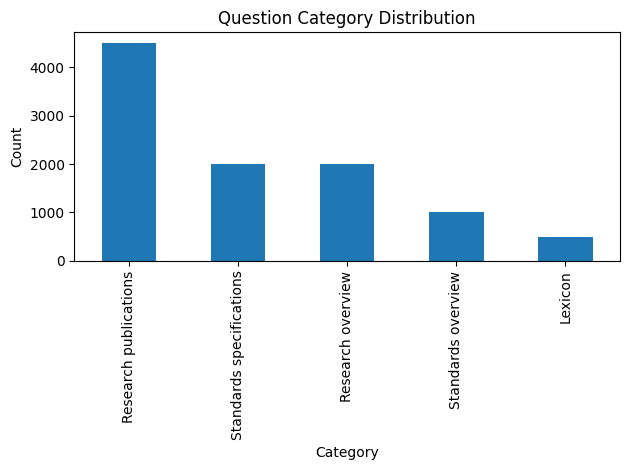

In [5]:
# Step 4: Exploratory Data Analysis (EDA)
import matplotlib.pyplot as plt
# 1. Question Category Distribution
category_counts = df["category"].value_counts()
print("\n Category Distribution:\n", category_counts)

# 2. Count Per Question
df["option_count"] = df["options"].apply(len)
print("\n Option Count Stats:\n", df["option_count"].describe())

# 3. Distribution of Correct Answer Positions
def extract_answer_label(answer):
    return re.search(r"option (\w+)", answer.lower()).group(1) if "option" in answer.lower() else "unknown"

df["answer_label"] = df["answer"].apply(extract_answer_label)
print("\n Answer Label Distribution:\n", df["answer_label"].value_counts())

# Plot category distribution
category_counts.plot(kind="bar", title="Question Category Distribution", ylabel="Count", xlabel="Category")
plt.tight_layout()
plt.show()

In [6]:
# Step 5: Save as Cleaned CSV
df_cleaned = df.drop(columns=["options"])
df_cleaned.to_csv("TeleQnA_cleaned.csv", index=False)
print("📁 Cleaned structured dataset saved as: TeleQnA_cleaned.csv")

📁 Cleaned structured dataset saved as: TeleQnA_cleaned.csv


In [7]:
# Step 6: Prepare Prompt → Completion Format
def format_prompt_completion(row):
    prompt = f"""### Question:
{row['question']}

### Options:
"""
    for idx, option in enumerate(row["options"], start=1):
        prompt += f"({idx}) {option}\n"
    
    completion = row["answer"].split(": ", 1)[-1].strip()
    return pd.Series([prompt.strip(), completion])

df[["prompt", "completion"]] = df.apply(format_prompt_completion, axis=1)

In [8]:
# Step 7: Save JSONL for LLaMA Fine-Tuning
jsonl_data = df[["prompt", "completion"]].to_dict(orient="records")

output_jsonl = "teleqna_finetune.jsonl"
with open(output_jsonl, "w", encoding="utf-8") as f:
    for record in jsonl_data:
        json.dump(record, f)
        f.write("\n")

print(f" Fine-tuning JSONL dataset saved as: {output_jsonl}")

✅ Fine-tuning JSONL dataset saved as: teleqna_finetune.jsonl


# TeleQuAD preprocessing

In [9]:
!pip install seaborn
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

output_dir = "output_telequad"
os.makedirs(output_dir, exist_ok=True)

In [10]:
 # PART 1: TeleQuAD Extractive Preprocessing

# Load extractive dataset
with open("TeleQuAD-v4-full.json", "r", encoding="utf-8") as f:
    telequad_v4 = json.load(f)

# Flatten extractive QA data
extractive_records = []
for entry in telequad_v4["data"]:
    source = entry.get("source", "")
    for para in entry.get("paragraphs", []):
        context = para.get("context", "")
        for qa in para.get("qas", []):
            question = qa.get("question", "")
            answer_list = qa.get("answers", [])
            answer_text = answer_list[0]["text"] if answer_list else ""
            extractive_records.append({
                "question": question.strip(),
                "context": context.strip(),
                "answer": answer_text.strip(),
                "source": source.strip()
            })

df_extractive = pd.DataFrame(extractive_records)
df_extractive["context_length"] = df_extractive["context"].str.len()
df_extractive["question_length"] = df_extractive["question"].str.len()

# Save cleaned CSV
df_extractive.to_csv(f"{output_dir}/telequad_cleaned.csv", index=False)

In [11]:
df_extractive

,question,context,answer,source,context_length,question_length
0,When deferring or rejecting a concurrent reque...,5.7\tSupport of Concurrent Location Requests\n...,LCS Client/AF priority and any other relevant ...,3GPP-Specs#23273-g50,3539,78
1,How can concurrent location requests be combined?,5.7\tSupport of Concurrent Location Requests\n...,by executing only one request and using the en...,3GPP-Specs#23273-g50,3539,49
2,What can be combined by an AMF?,5.7\tSupport of Concurrent Location Requests\n...,"concurrent 5GC-MT LR, 5GC-MO LR and 5GC-NI LR ...",3GPP-Specs#23273-g50,3539,31
3,What should be considered when cancelling one ...,5.7\tSupport of Concurrent Location Requests\n...,LCS Client/AF priority and any other relevant ...,3GPP-Specs#23273-g50,3539,75
4,What may combine requests from the H GMLC?,5.7\tSupport of Concurrent Location Requests\n...,the same target UE,3GPP-Specs#23273-g50,3539,42
...,...,...,...,...,...,...
4480,What is CDF?,3GPP-Specs#32240-f50#21\n\n4.3.3.2\tConverged ...,Charging Data Function,3GPP-Specs#32240-f50#21,487,12
4481,What is RF?,3GPP-Specs#32240-f50#21\n\n4.3.3.2\tConverged ...,Rating Function,3GPP-Specs#32240-f50#21,487,11
4482,What do the Charging Function include?,3GPP-Specs#32240-f50#21\n\n4.3.3.2\tConverged ...,Online Charging Function (OCF) and Charging Da...,3GPP-Specs#32240-f50#21,487,38
4483,What is CHF?,3GPP-Specs#32240-f50#21\n\n4.3.3.2\tConverged ...,Charging Function,3GPP-Specs#32240-f50#21,487,12


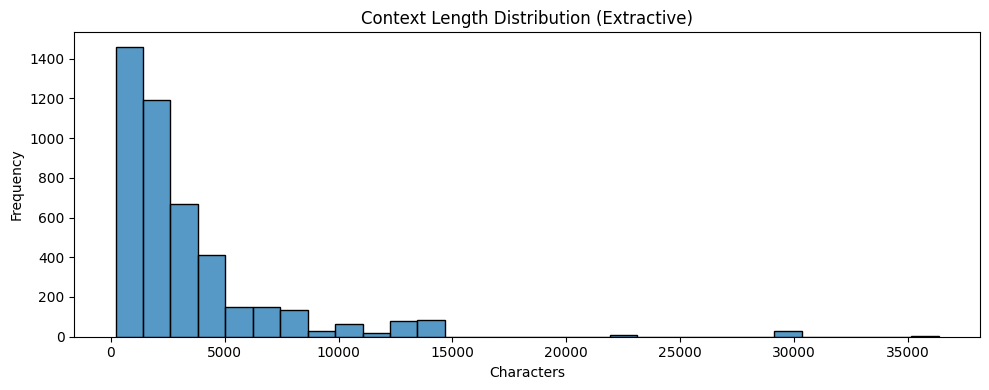

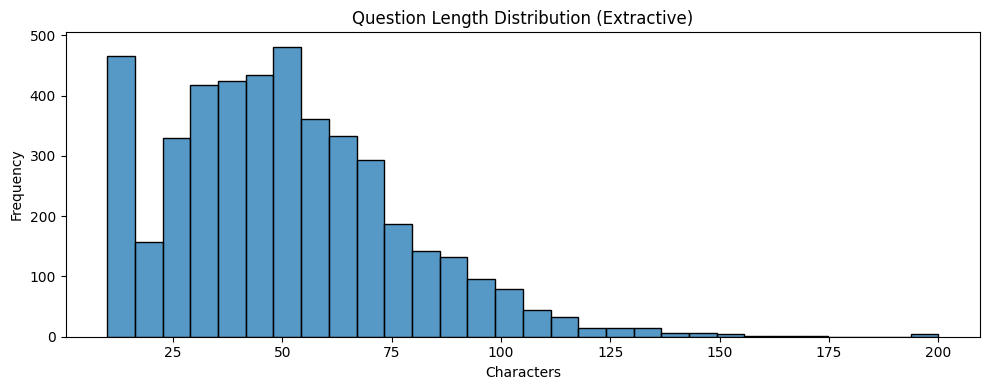

In [12]:
# ===  EDA: Extractive ===
plt.figure(figsize=(10, 4))
sns.histplot(df_extractive["context_length"], bins=30)
plt.title("Context Length Distribution (Extractive)")
plt.xlabel("Characters")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 4))
sns.histplot(df_extractive["question_length"], bins=30)
plt.title("Question Length Distribution (Extractive)")
plt.xlabel("Characters")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

In [13]:
# Prompt → Completion Format: Extractive
df_extractive["answer"] = df_extractive["answer"].fillna("")

def format_extractive(row):
    prompt = f"""### Task: extractive_qa
### Context:
{row['context']}

### Question:
{row['question']}

### Answer:"""
    completion = " " + row["answer"]
    return pd.Series([prompt.strip(), completion])

df_extractive[["prompt", "completion"]] = df_extractive.apply(format_extractive, axis=1)

In [14]:
df_extractive

,question,context,answer,source,context_length,question_length,prompt,completion
0,When deferring or rejecting a concurrent reque...,5.7\tSupport of Concurrent Location Requests\n...,LCS Client/AF priority and any other relevant ...,3GPP-Specs#23273-g50,3539,78,### Task: extractive_qa\n### Context:\n5.7\tSu...,LCS Client/AF priority and any other relevant...
1,How can concurrent location requests be combined?,5.7\tSupport of Concurrent Location Requests\n...,by executing only one request and using the en...,3GPP-Specs#23273-g50,3539,49,### Task: extractive_qa\n### Context:\n5.7\tSu...,by executing only one request and using the e...
2,What can be combined by an AMF?,5.7\tSupport of Concurrent Location Requests\n...,"concurrent 5GC-MT LR, 5GC-MO LR and 5GC-NI LR ...",3GPP-Specs#23273-g50,3539,31,### Task: extractive_qa\n### Context:\n5.7\tSu...,"concurrent 5GC-MT LR, 5GC-MO LR and 5GC-NI LR..."
3,What should be considered when cancelling one ...,5.7\tSupport of Concurrent Location Requests\n...,LCS Client/AF priority and any other relevant ...,3GPP-Specs#23273-g50,3539,75,### Task: extractive_qa\n### Context:\n5.7\tSu...,LCS Client/AF priority and any other relevant...
4,What may combine requests from the H GMLC?,5.7\tSupport of Concurrent Location Requests\n...,the same target UE,3GPP-Specs#23273-g50,3539,42,### Task: extractive_qa\n### Context:\n5.7\tSu...,the same target UE
...,...,...,...,...,...,...,...,...
4480,What is CDF?,3GPP-Specs#32240-f50#21\n\n4.3.3.2\tConverged ...,Charging Data Function,3GPP-Specs#32240-f50#21,487,12,### Task: extractive_qa\n### Context:\n3GPP-Sp...,Charging Data Function
4481,What is RF?,3GPP-Specs#32240-f50#21\n\n4.3.3.2\tConverged ...,Rating Function,3GPP-Specs#32240-f50#21,487,11,### Task: extractive_qa\n### Context:\n3GPP-Sp...,Rating Function
4482,What do the Charging Function include?,3GPP-Specs#32240-f50#21\n\n4.3.3.2\tConverged ...,Online Charging Function (OCF) and Charging Da...,3GPP-Specs#32240-f50#21,487,38,### Task: extractive_qa\n### Context:\n3GPP-Sp...,Online Charging Function (OCF) and Charging D...
4483,What is CHF?,3GPP-Specs#32240-f50#21\n\n4.3.3.2\tConverged ...,Charging Function,3GPP-Specs#32240-f50#21,487,12,### Task: extractive_qa\n### Context:\n3GPP-Sp...,Charging Function


In [15]:
# Save JSONL
with open(f"{output_dir}/telequad_extractive_finetune.jsonl", "w", encoding="utf-8") as f:
    for record in df_extractive[["prompt", "completion"]].to_dict(orient="records"):
        json.dump(record, f)
        f.write("\n")

print(" Extractive JSONL written!")

✅ Extractive JSONL written!


In [16]:
# PART 2: TeleQuAD Tabular Preprocessing

# Load tabular dataset
with open("TeleQuAD-v1-full-Tabular.json", "r", encoding="utf-8") as f:
    telequad_tabular = json.load(f)

# Extract and flatten
questions = telequad_tabular["data"][0]["questions"]
tabular_records = []
for q in questions:
    tabular_records.append({
        "question": q.get("question", "").strip(),
        "context": q.get("context", "").strip(),
        "answer": q.get("answer", "").strip(),
        "source": "TeleQuAD-v1-tabular"
    })

df_tabular = pd.DataFrame(tabular_records)
df_tabular["context_length"] = df_tabular["context"].str.len()
df_tabular["question_length"] = df_tabular["question"].str.len()
df_tabular["answer"] = df_tabular["answer"].fillna("")

# Save cleaned CSV
df_tabular.to_csv(f"{output_dir}/telequad_tabular_cleaned.csv", index=False)

In [17]:
df_tabular

,question,context,answer,source,context_length,question_length
0,What is the maximum end-to-end latency specifi...,[PR 5.1.5-1] The 5G system shall support the a...,200ms,TeleQuAD-v1-tabular,5190,63
1,How many PIN Elements are there in the service...,[PR 5.1.5-1] The 5G system shall support the a...,31,TeleQuAD-v1-tabular,5190,77
2,What is the maximum allowed inaccuracy for a b...,"As electric grids are expanding, there is an i...",Answer: <200ns,TeleQuAD-v1-tabular,3105,86
3,What is the estimated typical power load in th...,With the increased requirements for a more rel...,1043 MW,TeleQuAD-v1-tabular,5597,90
4,What is the estimated typical power load in th...,With the increased requirements for a more rel...,1348 MW,TeleQuAD-v1-tabular,5597,96
...,...,...,...,...,...,...
273,Which operation points have a sampling frequen...,The speech and audio Operation Points defined ...,"AMR-WB speech, EVS mono, AMR-WB+",TeleQuAD-v1-tabular,1723,59
274,How many service operations are supported by t...,"Within the 5GCN, the AMF offers services to th...",4,TeleQuAD-v1-tabular,1368,76
275,How many service operations have Subscribe/Not...,"Within the 5GCN, the AMF offers services to th...",3,TeleQuAD-v1-tabular,1368,70
276,Which service operations are supported by the ...,"Within the 5GCN, the AMF offers services to th...","NonUeN2MessageTransfer, NonUeN2InfoSubscribe, ...",TeleQuAD-v1-tabular,1368,73


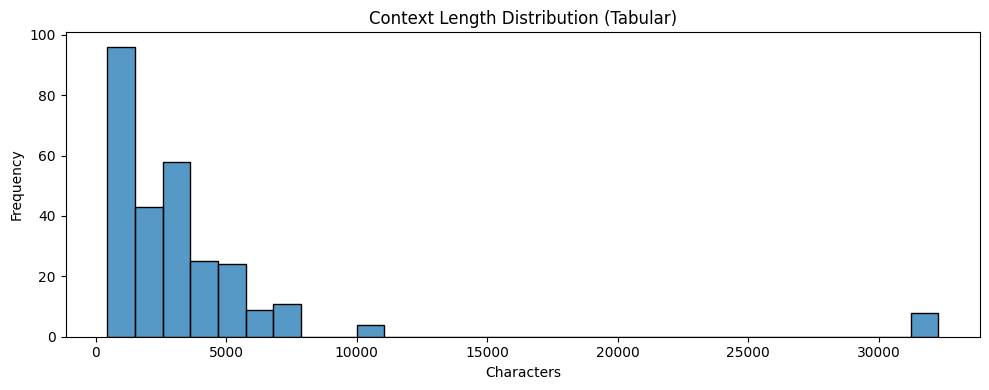

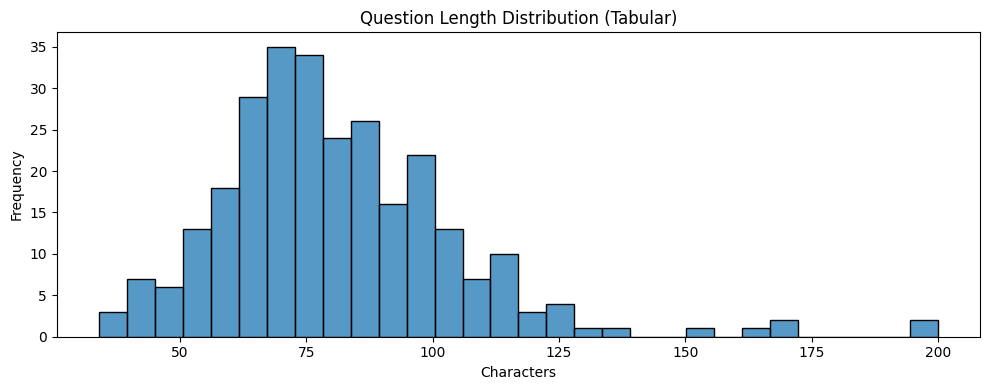

In [18]:
# EDA: Tabular
plt.figure(figsize=(10, 4))
sns.histplot(df_tabular["context_length"], bins=30)
plt.title("Context Length Distribution (Tabular)")
plt.xlabel("Characters")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 4))
sns.histplot(df_tabular["question_length"], bins=30)
plt.title("Question Length Distribution (Tabular)")
plt.xlabel("Characters")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

In [19]:
# Prompt → Completion Format: Tabular
def format_tabular(row):
    prompt = f"""### Task: tabular_qa
### Question:
{row['question']}

### Context:
{row['context']}

### Answer:"""
    completion = " " + row["answer"]
    return pd.Series([prompt.strip(), completion])

df_tabular[["prompt", "completion"]] = df_tabular.apply(format_tabular, axis=1)

In [20]:
# Save JSONL
with open(f"{output_dir}/telequad_tabular_finetune.jsonl", "w", encoding="utf-8") as f:
    for record in df_tabular[["prompt", "completion"]].to_dict(orient="records"):
        json.dump(record, f)
        f.write("\n")

print(" Tabular JSONL written!")

✅ Tabular JSONL written!


# 3gpp Preprocessing

In [21]:
# Step 1: Imports and configuration
!pip install tqdm
import os
import re
import json
import pandas as pd
from docx import Document
from tqdm import tqdm

In [22]:
# Step 2: Load DOCX files
docx_files = [
    "38104-j00.docx",
    "38300-i50.docx",
    "38306-i50.docx",
    "38331-i51.docx",
    "38401-i50.docx"
]

In [23]:
# Step 3: Extract paragraphs + section titles
section_pattern = re.compile(r'^\d+(\.\d+)*\s+[A-Z].+')
all_sections = []
all_paragraphs = []

for file in docx_files:
    doc = Document(file)
    current_section = "Unknown"
    for para in doc.paragraphs:
        text = para.text.strip()
        if not text:
            continue
        if section_pattern.match(text):
            current_section = text
            all_sections.append({"document": file, "section_title": current_section})
        else:
            all_paragraphs.append({
                "document": file,
                "section_title": current_section,
                "paragraph": text,
                "length": len(text)
            })

In [24]:
# Step 4: Show all unique section titles
section_df = pd.DataFrame(all_sections).drop_duplicates().reset_index(drop=True)
print(" Unique Section Titles:")
print(section_df["section_title"])

📘 Unique Section Titles:
0                                        1\tScope\t16
1                                   2\tReferences\t16
2       3\tDefinitions, symbols and abbreviations\t17
3                                3.1\tDefinitions\t17
4                                    3.2\tSymbols\t22
                            ...                      
3855                               10.3\tF1 interface
3856                               10.4\tE1 interface
3857     10.5\tAntenna interface - general principles
3858     11\tOverall procedures in NG-RAN Architecure
3859                    11.1\tMultiple TNLAs for Xn-C
Name: section_title, Length: 3860, dtype: object


In [25]:
# Step 5: Paragraph DataFrame for full use
df_paragraphs = pd.DataFrame(all_paragraphs)
print(" Total Paragraphs Extracted:", len(df_paragraphs))

✅ Total Paragraphs Extracted: 48473


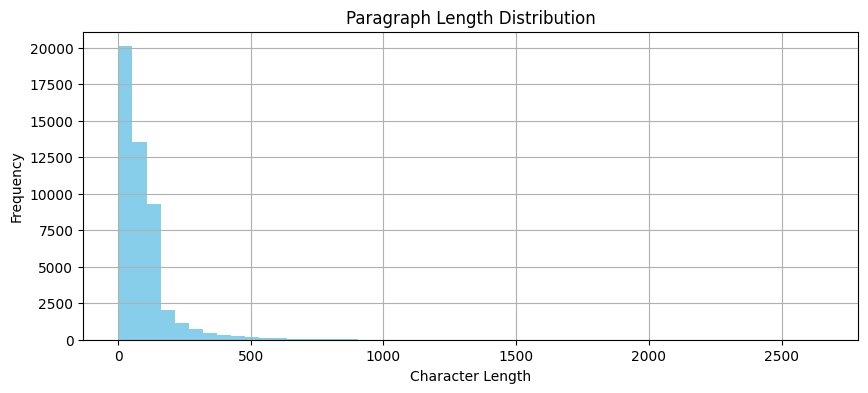

count    48473.000000
mean        91.697110
std        103.256044
min          1.000000
25%         34.000000
50%         68.000000
75%        119.000000
max       2656.000000
Name: length, dtype: float64


In [26]:
#Step 7: Paragraph EDA – length stats
df_paragraphs["length"].plot.hist(bins=50, figsize=(10,4), color="skyblue")
plt.title("Paragraph Length Distribution")
plt.xlabel("Character Length")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

print(df_paragraphs["length"].describe())

In [27]:
# Step 8: Prepare a clean version for QA generation
df_preview = df_paragraphs[["document", "section_title", "paragraph"]].copy()
df_preview["paragraph"] = df_preview["paragraph"].str.strip()
df_preview = df_preview[df_preview["paragraph"].str.len() > 50]  # Filter out very short lines

df_preview.sample(5)

,document,section_title,paragraph
1878,38104-j00.docx,11.1.2\tOTA demodulation branches,Radiated performance requirements are only spe...
4972,38300-i50.docx,16.3.3.1\tGeneral,To enable differentiated handling of traffic f...
35873,38331-i51.docx,6.3.3\tUE capability information elements,maxNumberSimulSRS-OneResourcePerSet-r18 IN...
11859,38331-i51.docx,5.3.13.1\tGeneral,Figure 5.3.13.1-3: RRC connection resume follo...
39155,38331-i51.docx,6.3.3\tUE capability information elements,maxNumberConfigs-r18 ...


In [28]:
len(df_preview)

30037

# RFC Preprocessing

In [29]:
import os
import pandas as pd
from pathlib import Path
from pdfminer.high_level import extract_text

# Set directory containing RFC PDF files
rfc_dir = Path(r"C:\Users\Rishabh\OneDrive\Desktop\THESIS\Code Notebooks")  # Replace with actual path
rfc_files = list(rfc_dir.glob("*.pdf"))

In [30]:
# Extract paragraphs from each PDF
paragraphs_data = []

for file in rfc_files:
    print(f"Processing: {file.name}")
    try:
        text = extract_text(file)
        sections = text.split('\n\n')
        for para in sections:
            clean_para = para.strip().replace('\n', ' ')
            if len(clean_para.split()) > 10:
                paragraphs_data.append({
                    "document": file.name,
                    "paragraph": clean_para
                })
    except Exception as e:
        print(f"Error processing {file.name}: {e}")

Processing: rfc1035.txt.pdf
Processing: rfc3261.txt.pdf
Processing: rfc768.txt.pdf
Processing: rfc791.txt.pdf


In [31]:
# Convert to DataFrame
df_rfc = pd.DataFrame(paragraphs_data)

# Save cleaned paragraphs
df_rfc.to_csv("rfc_all_paragraphs.csv", index=False)
print(" Saved to rfc_all_paragraphs.csv")

✅ Saved to rfc_all_paragraphs.csv


Total paragraphs: 2313
Docs: ['rfc1035.txt.pdf' 'rfc3261.txt.pdf' 'rfc768.txt.pdf' 'rfc791.txt.pdf']
count    2313.000000
mean      321.970169
std       307.250628
min        49.000000
25%       148.000000
50%       238.000000
75%       402.000000
max      3500.000000
Name: length, dtype: float64


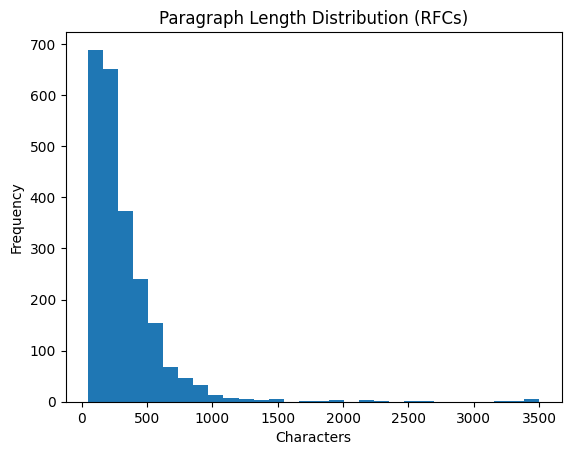

In [32]:
# Basic EDA
print("Total paragraphs:", len(df_rfc))
print("Docs:", df_rfc['document'].unique())

# longest and shortest paragraph
df_rfc["length"] = df_rfc["paragraph"].str.len()
print(df_rfc["length"].describe())

import matplotlib.pyplot as plt
plt.hist(df_rfc["length"], bins=30)
plt.title("Paragraph Length Distribution (RFCs)")
plt.xlabel("Characters")
plt.ylabel("Frequency")
plt.show()

In [33]:
#  Step 1: View random paragraphs
df_rfc.sample(5)[["document", "paragraph"]]

#  Step 2: View longest paragraphs (could be good for multi-hop QA)
df_rfc.sort_values(by="length", ascending=False).head(5)[["document", "paragraph", "length"]]

#  Step 3: View shortest paragraphs (may want to exclude later)
df_rfc.sort_values(by="length", ascending=True).head(5)[["document", "paragraph", "length"]]

#  Step 4: View a single document's content (e.g., only rfc1035)
df_rfc[df_rfc["document"].str.contains("1035")].sample(5)

#  Step 5: Filter by keyword (e.g., "header", "UDP", "transaction")
keyword = "UDP"
df_rfc[df_rfc["paragraph"].str.contains(keyword, case=False)].sample(5)

,document,paragraph,length
1298,rfc3261.txt.pdf,(1): The default port value is transport and s...,196
1952,rfc3261.txt.pdf,o RFC 2543 allowed multiple requests in a sin...,97
1686,rfc3261.txt.pdf,INVITE sip:bob@biloxi.com SIP/2.0 Via:...,531
1701,rfc3261.txt.pdf,SIP/2.0 180 Ringing Via: SIP/2.0/UDP server10....,457
599,rfc3261.txt.pdf,"In some cases, the response returned by the tr...",501


# Convert datasets (teleqna_finetune.jsonl and telequad_extractive_finetune.jsonl) into instruction-based format with instruction, input, and output fields

In [35]:
import json

def convert_teleqna_format(input_file, output_file):
    with open(input_file, 'r', encoding='utf-8') as infile, open(output_file, 'w', encoding='utf-8') as outfile:
        for line in infile:
            entry = json.loads(line.strip())
            formatted = {
                "instruction": "Answer the multiple-choice question based on your telecom knowledge.",
                "input": entry["prompt"],
                "output": entry["completion"].strip()
            }
            outfile.write(json.dumps(formatted) + "\n")

def convert_telequad_format(input_file, output_file):
    with open(input_file, 'r', encoding='utf-8') as infile, open(output_file, 'w', encoding='utf-8') as outfile:
        for line in infile:
            entry = json.loads(line.strip())
            formatted = {
                "instruction": "Extract the correct answer span from the telecom document context.",
                "input": entry["prompt"],
                "output": entry["completion"].strip()
            }
            outfile.write(json.dumps(formatted) + "\n")

if __name__ == "__main__":
    # Modify the paths as needed
    convert_teleqna_format(
        input_file="teleqna_finetune.jsonl",
        output_file="teleqna_instruction_format.jsonl"
    )

    convert_telequad_format(
        input_file="telequad_extractive_finetune.jsonl",
        output_file="telequad_instruction_format.jsonl"
    )

    print("Conversion complete. Files saved as:")
    print(" - teleqna_instruction_format.jsonl")
    print(" - telequad_instruction_format.jsonl")

Conversion complete. Files saved as:
 - teleqna_instruction_format.jsonl
 - telequad_instruction_format.jsonl
